In [23]:
import sys, os

# add TriplePandelReco directory to $PYTHONPATH.
sys.path.insert(0, "/home/storage/hans/jax_reco_gupta_corrections3")
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# load jax and make sure we use double precision
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp

# import network logic.
from lib.gupta_network_eqx_4comp import get_network_eval_fn

# import some required coordinate transformations
# see e.g. https://github.com/HansN87/TriplePandelReco_JAX/blob/gupta_4comp/dom_track_eval.py 
# for how these would be used in practice during reconstruction
from lib.trafos import transform_network_inputs
from lib.trafos import transform_network_outputs_gupta_4comp as transform_network_outputs

# import pdf and cdf of mixture of gupta distributions.
from lib.gupta import multi_gupta_pdf
from lib.gupta import multi_gupta_cdf

# we also want some plotting and other standard libraries
import numpy as np
import matplotlib.pyplot as plt

In [16]:
# generate network evaluation logic (gupta with 4 components) based on weights from TriplePandelReco data directory
# again: double precision.
dtype = jnp.float64

eval_network = get_network_eval_fn(bpath='/home/storage/hans/jax_reco_gupta_corrections3/data/gupta/n96_4comp/new_model_no_penalties_tree_start_epoch_800.eqx', dtype=dtype, n_hidden=96)

In [17]:
# here are some coordinates
dist = 10.0 # m
z = -500.0 # m
rho = 0.0 # radians
zenith = jnp.pi/2 # radians
azimuth = 0.0 # radians

x = jnp.array([dist, rho, z, zenith, azimuth])

# which we can now map to our pdf parameters (4-comp gupta) via the neural network
x_prime = transform_network_inputs(x)
y = eval_network(x_prime)
logits, gupta_a, gupta_b = transform_network_outputs(y)
mix_probs = jax.nn.softmax(logits)

In [20]:
print(mix_probs)
print(gupta_a)
print(gupta_b)

[0.21812866 0.54446058 0.16553877 0.07187199]
[3.42271704 9.67349643 1.51622567 1.01532541]
[0.19215694 0.88086436 0.02201497 0.0019263 ]


Text(0.5, 0, 'delay time [ns]')

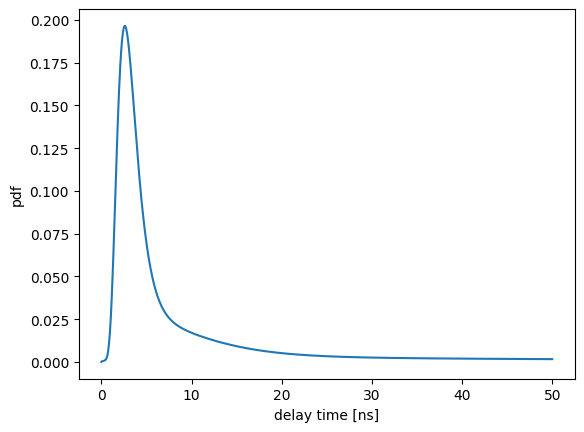

In [30]:
# make a plot of the gupta pdf for the chosen coordinates

delay_times = jnp.linspace(0.0, 50.0, 1000)
plt.plot(delay_times, multi_gupta_pdf(delay_times, mix_probs, gupta_a, gupta_b))
plt.ylabel("pdf")
plt.xlabel("delay time [ns]")

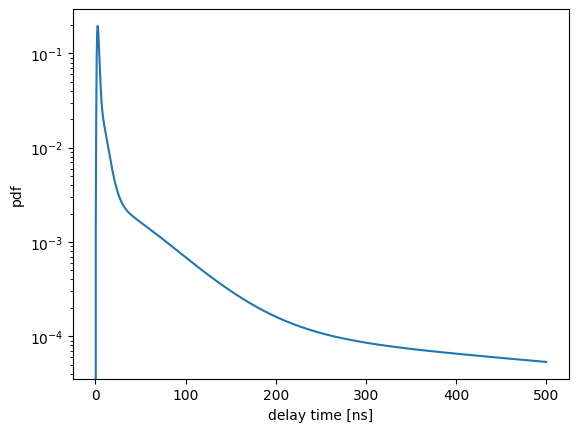

In [35]:
# and on log-scale

delay_times = jnp.linspace(0.0, 500.0, 1000)
plt.plot(delay_times, multi_gupta_pdf(delay_times, mix_probs, gupta_a, gupta_b))
plt.ylabel("pdf")
plt.xlabel("delay time [ns]")
plt.yscale('log')

In [31]:
# make a plot of the gupta cdf for the chosen coordinates

(0.0, 1.0)

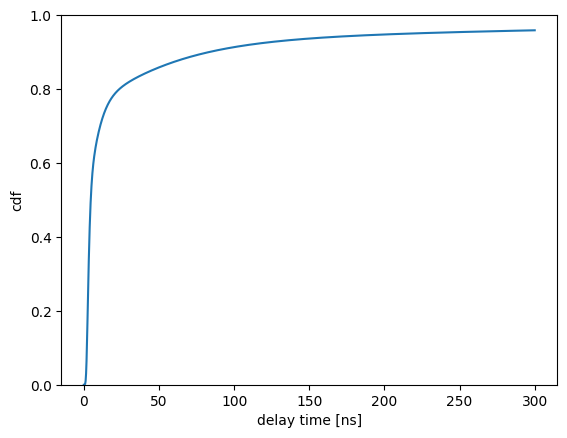

In [41]:
delay_times = jnp.linspace(0.0, 300.0, 1000)
plt.plot(delay_times, multi_gupta_cdf(delay_times, mix_probs, gupta_a, gupta_b))
plt.ylabel("cdf")
plt.xlabel("delay time [ns]")
plt.ylim([0.0, 1.0])

In [ ]:
# However, during reconstruction we are more interested in the MPE pdf, the pdf that describes the earliest time in
# a random sample of a given size (total charge for us). This is known as "first order statistic".
# https://en.wikipedia.org/wiki/Order_statistic

# a gaussian-convolved version of this is implemented here
# https://github.com/HansN87/TriplePandelReco_JAX/blob/76bcbb5c1ad5e98b4b027e73e4ee7b0af7dbd4c9/lib/gupta.py#L191
# but for now we just code a version without convolution.